In [1]:
# Preamble
from astropy.table import Table, column
import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

In [2]:
import sys
sys.path.append('../astro_codes/')

### First task is to load all of the data we require

In [3]:
gz_data = Table.read('../fits/full_sample_debiased_w_low_z.fits') # galaxies data

In [4]:
sparcfire_g = Table.read('../sparcfire_directories/main/sparcfire_g_matched.fits') # sparcfire data

In [5]:
samples = Table.read('../fits/SF_fits/samples.fits') # samples (eg. spirals)

In [6]:
import pandas as pd
sparcfire_g_arcs = pd.read_csv('../sparcfire_directories/g/g.galaxy_arcs.csv') # individual arc data

/home/ppxrh/anaconda3/lib/python3.4/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


### Sample selection

Use the same sample as in Hart+ submitted: 

- Spiral ($p_\mathrm{spiral} > 0.5$ and $N_\mathrm{spiral}\geq5$)

- Unbarred ($p_\mathrm{bar} < 0.5$) 

- Face-on ($(b/a)_g > 0.4$) 

- Low-redshift ($0.03<z\leq0.055$)

Here we also define some statistics form the GZ2 data itself:

- $w$= most populous winding answer (1=tight, 2=medium, 3=loose)

- $w_\mathrm{wtd \, avg}$= $p_\mathrm{tight}$ + $2(p_\mathrm{medium})$ + $3(p_\mathrm{loose})$

In [7]:
in_spiral = (samples['all_spiral']) & (samples['in_mass_limit'])
in_sparcfire = sparcfire_g['fit_state'] == 'OK'
in_both = (in_spiral) & (in_sparcfire)
ids = gz_data['dr8objid'][in_both]

# Measure m and w values:
def measure_weighted_average(data,columns):
    p_array = np.array([data[c] for c in columns]).T
    p_array[np.isfinite(p_array) == False] = 0
    p_mean = np.zeros(len(p_array))
    p_sum = np.sum(p_array,axis=1)
    for c in range(len(columns)):
        p_mean += (c+1)*p_array[:,c]
    p_mean = p_mean/p_sum
    p_mean[np.isfinite(p_mean) == False] = 0
    p_absolute = np.argmax(p_array,axis=1) + 1
    return p_mean, p_absolute

m_columns = ['t11_arms_number_a31_1_debiased_rh',
             't11_arms_number_a32_2_debiased_rh',
             't11_arms_number_a33_3_debiased_rh',
             't11_arms_number_a34_4_debiased_rh',
             't11_arms_number_a36_more_than_4_debiased_rh']

w_columns =  ['t10_arms_winding_a28_tight_debiased_rh',
              't10_arms_winding_a29_medium_debiased_rh',
              't10_arms_winding_a30_loose_debiased_rh']

m_wtd_average, m_absolute = measure_weighted_average(gz_data,m_columns)
w_wtd_average, w_absolute = measure_weighted_average(gz_data,w_columns)
gz_statistics = Table(np.array([m_wtd_average,m_absolute,w_wtd_average,w_absolute]).T,
                      names=('m_wtd_avg','m','w_wtd_avg','w'),
                      dtype=(float,int,float,int))

gz_statistics_both = gz_statistics[in_both]

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in true_divide


### Look up the arcs associated with each of the galaxies in our spiral sample.

A table with a _list_ of elements for the arc statisitics will be created.

- arc_table: table of arc statistics for our spiral sample only (~2,000 galaxies).

- arc_table_all: a table withe same number of rows as the entire sample of GZ2 galaxies (~250,000 galaxies).

In [1]:
from lookup_arcs import ArcLookup, ArcStats
'''
id_column = np.array(sparcfire_g['name']).astype(np.int64)
chirality_column = np.array(sparcfire_g['chirality_wtdPangSum'] == 'S-wise').astype(np.int)
chi_array = np.array([id_column,chirality_column]).T
# Lookup galaxies
arc_table = Table(names=('id','N','P','L','intensity','N_pixels','L_f'),
                  dtype=(int,int,object,object,object,object,object))
for id_ in ids:
    a = arc_lookup(id_)
    chi = a.chirality(chi_array)
    arc_list = a.arc_list(sparcfire_g_arcs,chi)
    arc_table.add_row(arc_list)
    
arc_table_all = Table(np.zeros((len(gz_data),7)),
                      names=('id','N','P','L','intensity','N_pixels','L_f'),
                      dtype=(int,int,object,object,object,object,object))

arc_table_all[in_both] = arc_table
'''

"\nid_column = np.array(sparcfire_g['name']).astype(np.int64)\nchirality_column = np.array(sparcfire_g['chirality_wtdPangSum'] == 'S-wise').astype(np.int)\nchi_array = np.array([id_column,chirality_column]).T\n# Lookup galaxies\narc_table = Table(names=('id','N','P','L','intensity','N_pixels','L_f'),\n                  dtype=(int,int,object,object,object,object,object))\nfor id_ in ids:\n    a = arc_lookup(id_)\n    chi = a.chirality(chi_array)\n    arc_list = a.arc_list(sparcfire_g_arcs,chi)\n    arc_table.add_row(arc_list)\n    \narc_table_all = Table(np.zeros((len(gz_data),7)),\n                      names=('id','N','P','L','intensity','N_pixels','L_f'),\n                      dtype=(int,int,object,object,object,object,object))\n\narc_table_all[in_both] = arc_table\n"

In [11]:
# This is the class I will use to measure statistics on arc_table.

class ArcStats():
    
    
    def __init__(self,arc_table):
        self.arc_table = arc_table
        self.N_rows = len(arc_table)
        self.setup_array = np.zeros(self.N_rows)
        
    def value_to_array(self,value=0,variable_name='i'):
        N_rows = self.N_rows
        if (isinstance(value,int)) or (isinstance(value,float)):
            return np.full(N_rows,value)
        else:
            if len(value) != N_rows:
                raise ValueError('Length of variable {} does not'
                                 'match number of rows'.format(variable_name))
            else:
                return value
        
    def N_arcs_L(self,px=55):
        px_array = self.value_to_array(px)
        N = self.setup_array
        for r in range(self.N_rows):
            L_r = np.array(arc_table['L'][r])
            N[r] = (L_r > px_array[r]).sum()
        return N
    
    def N_arcs_Lf(self,f=0.5):
        f_array = self.value_to_array(f)
        N = self.setup_array
        for r in range(self.N_rows):
            L_r = np.array(arc_table['L_f'][r])
            N[r] = (L_r > f_array[r]).sum()
        return N
    
    def L_total(self,px=55):
        px_array = self.value_to_array(px)
        L = self.setup_array
        for r in range(self.N_rows):
            L_r = np.array(arc_table['L'][r])
            ok_L = L_r > px_array[r]
            L[r] = L_r[ok_L].sum()
        return L
    
    def P_average(self,px=55,weighted_average=True,absolute=True):
        px_array = self.value_to_array(px)
        P = self.setup_array
        for r in range(self.N_rows):
            L_r = np.array(arc_table['L'][r])
            P_r = np.array(arc_table['P'][r])
            ok_L = L_r > px_array[r]
            if weighted_average is True:
                weights = np.array(arc_table['L_f'][r])[ok_L]
            else:
                weights = None
            if ok_L.sum() == 0:
                P[r] = 0
            else:
                P[r] = np.average(P_r[ok_L],weights=weights)
        if absolute is True:
            return np.absolute(P)
        else:
            return P
        
    def N_weighted_average(self,px=0):
        px_array = self.value_to_array(px)
        N_wtd_avg = self.setup_array
        N_rows = self.N_rows
        for r in range(N_rows):
            L_r = np.array(arc_table['L'][r])
            Lf_r = np.array(arc_table['L_f'][r])
            ok_L = L_r > px_array[r]
            if ok_L.sum() > 0:
                N_wtd_avg[r] = (Lf_r[ok_L]).sum()
            else:
                N_wtd_avg[r] = 0
        return N_wtd_avg

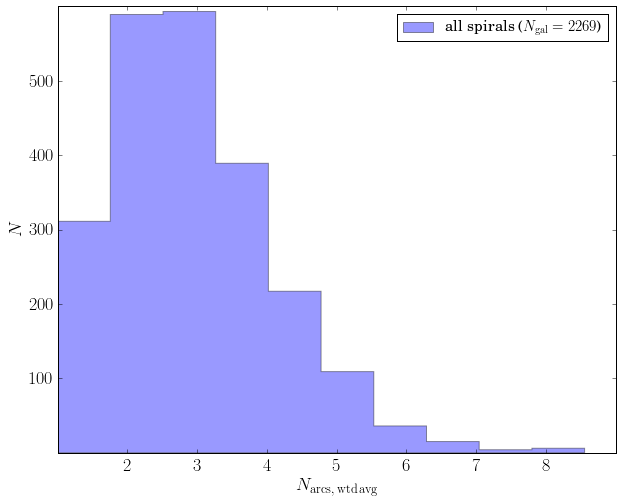

In [12]:
arc_statistics = ArcStats(arc_table)

x =  arc_statistics.N_weighted_average()
y = gz_statistics_both['m']

_ = plt.hist(x,color='b',alpha=0.4,histtype='stepfilled',
             label='all spirals ($N_\mathrm{{gal}}={}$)'.format(len(x)))
plt.xlabel('$N_\mathrm{arcs, \, wtd \, avg}$')
plt.ylabel('$N$')
plt.legend(fontsize=15)

In [13]:
from bin_statistics import assign_bins
from sklearn.utils import resample
'''
def bootstrap(data,function,n_resamples=10):
    values = np.empty(n_resamples)
    for n in range(n_resamples):
        if isinstance(data,(list,tuple)) is True:
            for d in data:
                print(d)
                resample(d,samples=d.size)
            n_sample = [resample(d,n_samples=d.size,random_state=n) for d in data]
            #values[n] = function(*n_sample)
        else:
            n_sample = resample(data,n_samples=d1.size,random_state=n)
            values[n] = function(n_sample)
    return values
'''

def get_best_z(x,y,z_values,arc_table):
    fracs = np.empty(z_values.size)
    for j, z in enumerate(z_values):
        N_arcs = ArcStats(arc_table).N_weighted_average(z)
        frac = (N_arcs/y_b).mean()
        fracs[j] = np.absolute(frac-1)
    best_z = z_values[fracs.argmin()]
    return best_z

x =  arc_statistics.N_weighted_average(0)
y = gz_statistics_both['m']
x_bins = assign_bins(x,N_bins=20)
unique_x_bins = np.unique(x_bins)

best_z = np.empty(unique_x_bins.size)
x_mean = np.empty(unique_x_bins.size)

z_values = np.linspace(0,100,101)
#fracs = np.empty(z_values.size)

for i, b in enumerate(np.unique(x_bins)):
    in_bin = x_bins == b
    x_b = x[in_bin]
    y_b = y[in_bin]
    x_mean[i] = (x_b).mean()
    best_z[i] = get_best_z(x_b,y_b,z_values,arc_table[in_bin])

/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


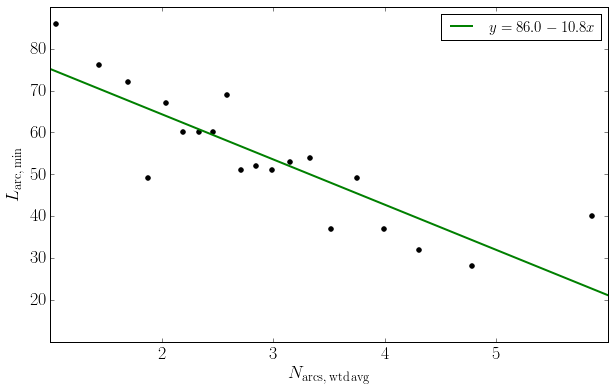

In [47]:
from scipy.optimize import curve_fit

def linear(x,m,c):
    return m*x + c

fig = plt.figure(figsize=(10,6))
ax = plt.subplot(111)

_ = ax.scatter(x_mean,best_z,marker='o',color='k')
plinear, _ = curve_fit(linear,x_mean,best_z)
x_guide = np.linspace(1,6,1000)
_ = ax.plot(x_guide,linear(x_guide,*plinear),color='g',lw=2,
             label='$y={}{}x$'.format(np.round(plinear[1],1),np.round(plinear[0],1)))
ax.set_xlim(x_guide[0],x_guide[-1])
ax.set_xlabel('$N_\mathrm{arcs, \, wtd \, avg}$')
ax.set_ylabel('$L_\mathrm{arc, \,  min}$')
ax.legend(fontsize=15)

fig.savefig('L_vs_N.pdf')

In [15]:
# Now, remove the arc lengths according to N_wtd_avg?
L_variable = linear(ArcStats(arc_table).N_weighted_average(),*plinear)
N_wtd_avg = ArcStats(arc_table).N_weighted_average(L_variable)
ok_arcs = N_wtd_avg > 0
print('{}/{} have > 1 arcs'.format(ok_arcs.sum(),ok_arcs.size))
#_ = plt.scatter(N_wtd_avg,gz_statistics_both['m_wtd_avg'],alpha=0.4)

2155/2269 have > 1 arcs


In [40]:
def arm_number_stack(x,bins,value='m',plot_medians=True,color='b',
                     fig=None,axarr=None,reference_x=None,
                     **kwargs):
    x_bins = np.digitize(x,bins)
    unique_bins = np.unique(x_bins)
    unique_bins = unique_bins[1:] if 0 in unique_bins else unique_bins
    n_bins = len(unique_bins)
    if (fig is None) | (axarr is None):
        fig, axarr = plt.subplots(n_bins,1,figsize=(10,3*n_bins),
                                  sharex=True,sharey=True)
    fig.subplots_adjust(hspace=0)
    if value is 'm':
        histogram_bins = np.linspace(0.5,5.5,6)
        axarr[-1].set_xlabel('$m$')
    else:
        histogram_bins = np.linspace(0.75,5.25,10)
        axarr[-1].set_xlabel('$m_\mathrm{wtd \, avg}$')
    axarr[-1].set_xlim(histogram_bins[0],histogram_bins[-1])    
    
    for b, bin_ in enumerate(unique_bins):
        in_bin = x_bins == bin_
        h = gz_statistics_both[value][in_bin]
        plt.sca(axarr[b])
        if reference_x is not None:
            axarr[b].hist(reference_x,bins=histogram_bins,normed=True,
                          histtype='stepfilled',color='k',alpha=0.4)
            axarr[b].hist(reference_x,bins=histogram_bins,normed=True,
                          histtype='step',color='k')
        axarr[b].hist(h,bins=histogram_bins,color=color,**kwargs)
        axarr[b].set_ylabel('normalised \n density')
        if plot_medians is True:
            for line in (np.median(h),np.percentile(h,16),np.percentile(h,84)):
                plt.axvline(line,color=color,linewidth=2,
                                  linestyle='dashed')
        
    return fig, axarr


def winding_stack(x,bins,value='w',plot_means=True,
                  fig=None,axarr=None,reference_x=None,
                  color='b',**kwargs):
    x_bins = np.digitize(x,bins)
    unique_bins = np.unique(x_bins)
    unique_bins = unique_bins[1:] if 0 in unique_bins else unique_bins
    n_bins = len(unique_bins)
    if (fig is None) | (axarr is None):
        fig, axarr = plt.subplots(n_bins,1,figsize=(10,3*n_bins),
                                  sharex=True,sharey=True)

    fig.subplots_adjust(hspace=0)
    if value is 'w':
        histogram_bins = np.linspace(0.5,3.5,4)
        axarr[-1].set_xlabel('$w$')
        axarr[-1].set_xticks([1,2,3])
        axarr[-1].set_xticklabels(['tight','medium','loose'])
    else:
        histogram_bins = np.linspace(0.75,3.25,6)
        axarr[-1].set_xlabel('$w_\mathrm{wtd \, avg}$')
        
    axarr[-1].set_xlim(histogram_bins[0],histogram_bins[-1])    
    
    for b, bin_ in enumerate(unique_bins):
        in_bin = x_bins == bin_
        h = gz_statistics_both[value][in_bin]
        plt.sca(axarr[b])
        if reference_x is not None:
            axarr[b].hist(reference_x,bins=histogram_bins,normed=True,
                          histtype='stepfilled',color='k',alpha=0.4)
            axarr[b].hist(reference_x,bins=histogram_bins,normed=True,
                          histtype='step',color='k')
        axarr[b].hist(h,bins=histogram_bins,**kwargs)
        axarr[b].set_ylabel('normalised \n density')
        if plot_means is True:
            for line in (np.mean(h),np.mean(h)-np.std(h),np.mean(h)+np.std(h)):
                plt.axvline(line,color='b',linewidth=2,
                                  linestyle='dotted')
    plt.sca(axarr[-1])

    return fig, axarr

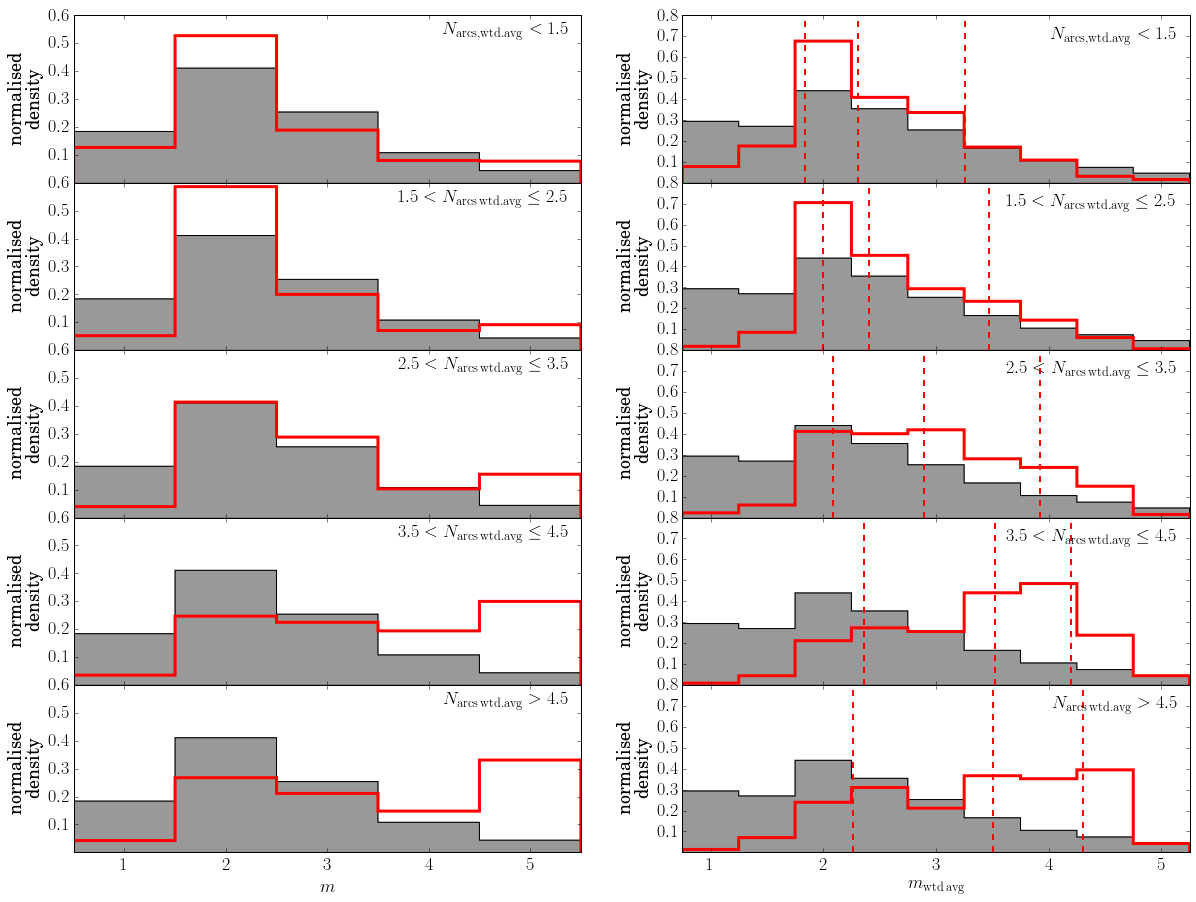

In [42]:
bins = np.linspace(0.5,5.5,6)
bins[-1] += 10

fig, axarr = plt.subplots(5,2,figsize=(20,15),
                          sharex='col',sharey='col')
fig.subplots_adjust(hspace=0)

_ = arm_number_stack(N_wtd_avg,bins,plot_medians=False,
                     fig=fig,axarr=axarr[:,0],reference_x=N_wtd_avg,
                     histtype='step',linewidth=3,color='r',
                     normed=True)

labels = ['$N_\mathrm{{arcs, wtd. avg}} < 1.5$',
          '$1.5 < N_\mathrm{{arcs\,  wtd. avg}} \leq 2.5$',
          '$2.5 < N_\mathrm{{arcs \, wtd. avg}} \leq 3.5$',
          '$3.5 < N_\mathrm{{arcs \, wtd. avg}} \leq 4.5$',
          '$N_\mathrm{{arcs \, wtd. avg}} > 4.5$']

for a, ax in enumerate(axarr[:,0]):
    ax.text(0.975,0.95,labels[a],
            ha='right',va='top',transform=ax.transAxes)

_ = arm_number_stack(N_wtd_avg,bins,value='m_wtd_avg',
                     fig=fig,axarr=axarr[:,1],reference_x=N_wtd_avg,
                     histtype='step',linewidth=3,color='r',
                     normed=True)

for a, ax in enumerate(axarr[:,1]):
    ax.text(0.975,0.925,labels[a],
            ha='right',va='top',transform=ax.transAxes)
    
fig.savefig('m_histograms.pdf')

/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


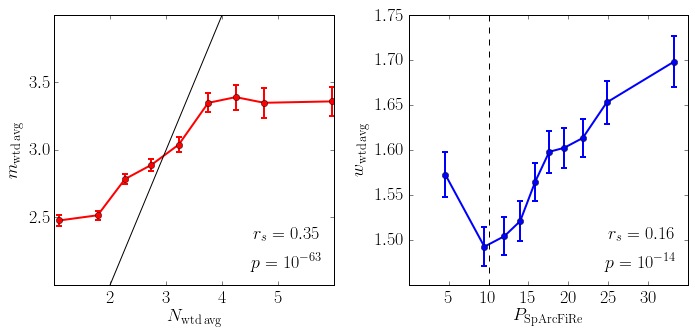

In [43]:
# ok, from our new method, what do the pitch angles look like?
from xy_plots import x_vs_y
from scipy.stats import spearmanr

fig,axarr = plt.subplots(1,2,figsize=(10,5))

ax = axarr[0]

x = N_wtd_avg
y = gz_statistics_both['m_wtd_avg']
ok_P = x > 0
bins = np.linspace(1,5.5,10)
bins[-1] += 10

xy = x_vs_y(x[ok_P],y[ok_P])
_ = xy.continuous_vs_continuous_binned(ax,bins=bins,equal_N=False,
                                       color='r',linewidth=2,marker='o',capthick=2)

xy.show_spearmanr(ax,'lower right')
ax.plot([1,5],[1,5],'k-')
ax.set_xlim(1,6)
ax.set_ylim(2,4)
ax.set_xlabel('$N_\mathrm{wtd \, avg}$')
ax.set_ylabel('$m_\mathrm{wtd \, avg}$')

##################################
ax = axarr[1]

x = ArcStats(arc_table).P_average(L_variable)
y = gz_statistics_both['w_wtd_avg']
ok_P = x > 0

xy = x_vs_y(x[ok_P],y[ok_P])
_ = xy.continuous_vs_continuous_binned(ax,bins=10,equal_N=True,
                                       color='b',linewidth=2,marker='o',capthick=2)
_ = xy.show_spearmanr(ax,'lower right')

ax.set_xlabel('$P_\mathrm{SpArcFiRe}$')
ax.set_ylabel('$w_\mathrm{wtd \, avg}$')
plt.sca(axarr[1])
plt.axvline(10,color='k',linestyle='dashed')

fig.tight_layout()

fig.savefig('sparcfire_vs_gz2.pdf')